In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import glob
import pickle
import os
os.chdir(r'C:\Users\dnguyen52\Box\college\pitlaResearch\crop-weed-discrimination\net-tool')

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (19.0, 17.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preprocessing

In [5]:
def get_data(stack_bias=False, save_path=None, load_path=None, datatype='float32'):
    data_dir = r'C:\Users\dnguyen52\Box\college\pitlaResearch\dataset\dataset\\'
    classes = ['broadleaf', 'grass', 'soil', 'soybean'] 
    n_cls = len(classes)
    data = {}
    #Just load the data not need to preprocess
    if(load_path is not None):
        with open(load_path, 'rb') as handle:
            data = pickle.load(handle)
    else:
        num_file_each_cls = 1100 
        total_files =num_file_each_cls*n_cls
        num_val_test = 50
        num_train = num_file_each_cls - num_val_test - num_val_test
        # Image dimension
        im_width = 200
        im_height = 200 
        im_channel = 3
        dim = im_width * im_height * im_channel
        
        all_files = [] 
        
        Y = np.zeros(total_files)


        for i, cls in enumerate(classes):
            all_files += [f for f in glob.glob(data_dir+cls+'\*.tif')][:num_file_each_cls]
            Y[i*num_file_each_cls:(i+1)*num_file_each_cls] = i # label all classes with int [0.. len(classes)]

        X = np.ndarray(shape=(total_files, im_width, im_height, im_channel), dtype=datatype)

        for idx, file in enumerate(all_files):
            X[idx] = cv2.resize(cv2.imread(file), (im_width, im_height))

        data['X_train'] = np.empty(shape=(num_train*n_cls,im_width, im_height, im_channel), dtype=datatype)
        data['X_val'] = np.empty(shape=(num_val_test*n_cls,im_width, im_height, im_channel), dtype=datatype)
        data['X_test'] = np.empty(shape=(num_val_test*n_cls,im_width, im_height, im_channel), dtype=datatype)

        data['y_train'] = np.empty(num_train*n_cls).astype(int)
        data['y_val'] = np.empty(num_val_test*n_cls).astype(int)
        data['y_test'] = np.empty(num_val_test*n_cls).astype(int) 
        
        for i, cls in enumerate(classes): 
            data['X_test'][num_val_test*i:num_val_test*(i+1)] = X[np.where(Y == i)[0][:num_val_test]]
            data['X_val'][num_val_test*i:num_val_test*(i+1)] = X[np.where(Y == i)[0][num_val_test:num_val_test*2]]
            data['X_train'][num_train*i:num_train*(i+1)] = X[np.where(Y == i)[0][num_val_test*2:]]

            data['y_test'][num_val_test*i:num_val_test*(i+1)] = i
            data['y_val'][num_val_test*i:num_val_test*(i+1)] = i
            data['y_train'][num_train*i:num_train*(i+1)] = i

        del Y 
        del X

        # Extract features 
        #Shuffle training index
        train_idxs = np.random.permutation(data['X_train'].shape[0])
        data['y_train']  = data['y_train'][train_idxs].astype(int)
        data['X_train'] = data['X_train'][train_idxs]

        data['X_train'] = np.reshape(data['X_train'], (data['X_train'].shape[0], -1)).astype(datatype)
        data['X_test'] = np.reshape(data['X_test'], (data['X_test'].shape[0], -1)).astype(datatype)
        data['X_val'] = np.reshape(data['X_val'], (data['X_val'].shape[0], -1)).astype(datatype)
    

            
    # If user want to save preprocessed data
    if(save_path is not None):
        with open(save_path, 'wb') as handle:
            pickle.dump(data, handle)
    
    ##NORMALIZE
    #Subtract out the mean image 
    #first: compute the mean image
    # mean_image = np.mean(X_train, axis=0) #axis=0. stack horizontally
    mean_image = 128# Since there are black background then just use 128 as mean. 
    #Second subtract the mean image from train and test data 
    data['X_train'] -= mean_image
    data['X_val'] -= mean_image 
    data['X_test'] -= mean_image
    
    num_tiny = 10
    data['X_tiny'] = data['X_train'][:num_tiny]
    data['y_tiny'] = data['y_train'][:num_tiny].astype(int)
    
    num_dev = 300
    data['X_dev'] = data['X_train'][0:num_dev]
    data['y_dev'] = data['y_train'][0:num_dev]



    
    if(stack_bias):
        #Third append the bias dimension using linear algebra trick
        #Not for net
        data['X_train'] = np.hstack([data['X_train'], np.ones((data['X_train'].shape[0], 1))])
        data['X_val'] = np.hstack([data['X_val'], np.ones((data['X_val'].shape[0], 1))])
        data['X_test'] = np.hstack([data['X_test'], np.ones((data['X_test'].shape[0], 1))])
        data['X_dev'] = np.hstack([data['X_dev'], np.ones((data['X_dev'].shape[0], 1))])
        data['X_tiny'] = np.hstack([data['X_tiny'], np.ones((data['X_tiny'].shape[0], 1))])
    
    
    
    return data

### TO Save the preprocessing data.
- **Check if the preprocess have been save.**


In [6]:
################################CHECK if the preprocessed file exist to save time##########################################
# save_path = r'C:\Users\dnguyen52\Box\college\pitlaResearch\dataset\dataset\dataset.pickle'
# data = get_data(stack_bias=False, save_path=save_path, load_path=None, datatype='float32')
# X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_tiny, y_tiny = data['X_train'], data['y_train'], data['X_val'], data['y_val'], data['X_test'], data['y_test'], data['X_dev'], data['y_dev'], data['X_tiny'], data['y_tiny']
###########################################################################################################################

In [7]:
load_path = r'C:\Users\dnguyen52\Box\college\pitlaResearch\dataset\dataset\dataset.pickle'
data = get_data(stack_bias=False, save_path=None, load_path=load_path, datatype='float32')
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']
X_dev, y_dev = data['X_dev'], data['y_dev']
X_tiny, y_tiny = data['X_tiny'], data['y_tiny']

In [8]:
print("X_train shape", X_train.shape, "| y_train shape:", y_train.shape)
print("X_test shape", X_test.shape, "| y_test shape:", y_test.shape)
print("X_val shape", X_val.shape, "| y_val shape:", y_val.shape)
print("X_dev shape", X_dev.shape, "| y_dev shape:", y_dev.shape)
print("X_tiny shape", X_tiny.shape, "| y_tiny shape:", y_tiny.shape)

X_train shape (4000, 120000) | y_train shape: (4000,)
X_test shape (200, 120000) | y_test shape: (200,)
X_val shape (200, 120000) | y_val shape: (200,)
X_dev shape (300, 120000) | y_dev shape: (300,)
X_tiny shape (10, 120000) | y_tiny shape: (10,)


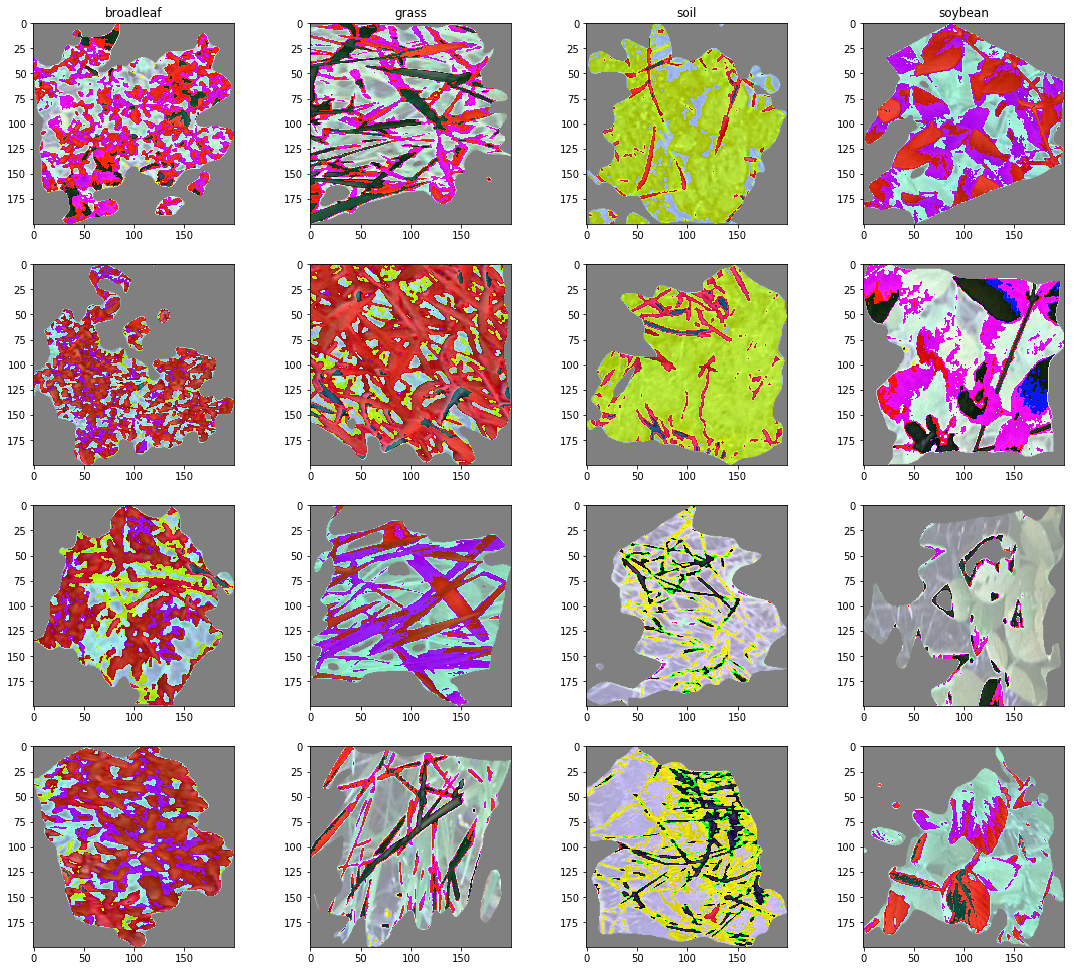

In [9]:
# Visualize some images 
# Make sure that everything when OK
classes = ['broadleaf', 'grass', 'soil', 'soybean']
n_class = len(classes)
samples_per_class = 4

# Image dimension
im_width = 200
im_height = 200 
im_channel = 3


for y, cls in enumerate(classes):
    idxes = np.flatnonzero(y == y_train)
    idxes = np.random.choice(idxes, samples_per_class, replace = False)
    for i, idx in enumerate(idxes):
        plt_idx = i * n_class + y + 1
        plt.subplot(samples_per_class,n_class, plt_idx)
        plt.imshow(X_train[idx].reshape(im_width, im_height, im_channel).astype('uint8'))
        if(i==0): plt.title(cls)

plt.show()

## Test Dataset with difference optimizing technique

#### Test with difference optimization technique
### Experiment
- Dev set of 300 data point is extracted out to investigate the best optimizing technique on this soyweed dataset
- Network architecture. 
```
[affine <-> batchnorm <-> relu]*3 <-> affine <-> softmax
```

### Result
- By Visualizing the Loss History curve below(top figure), One can conclude that there exist a local minimum at the begining of the train in the gradient space. vanilla SGD optimizer is stucked at the local minima. Same as SGD+momentum
- RMS prop and Adam were able to go over local minimum by keeping momentum and the square gradient. 

### Winner Optimizer
- `RMS prop` - Loss curve and validation accuracies is more stable

In [130]:
#Import necessary package to build net model
import nettool
from nettool.trainer import *
from nettool.layers import * 
from nettool.layer_utils import * 
from nettool.models import NeuralNet





train_data = {} 
train_data['X'] = data['X_dev']
train_data['y'] = data['y_dev'] 
train_data['X_val'] = data['X_val']
train_data['y_val'] = data['y_val']

optim = ['sgd', 'sgd_momentum','rmsprop','adam']
optim_hist = []

for o in optim:
    print("Training with", o)
    model = NeuralNet.NeuralNet(hidden_dims = [100, 100, 100], 
                input_dim = im_channel * im_height * im_width,
                num_classes = np.max(y_train) + 1, 
                dropout = 1.0,
                normalization = 'batchnorm', 
                reg = 0.0,
                weight_scale = 1e-3)
    
    trainer = Trainer(model, train_data, 
                     update_rule=o,
                     optim_config={
                         'learning_rate': 1e-3
                     },
                     lr_decay=0.95,
                     num_epochs=10, batch_size=100,
                     print_every=50)
    trainer.train()
    optim_hist.append((trainer.loss_history, trainer.train_acc_history, trainer.val_acc_history))
    del model 
    del trainer

Training with sgd
Training...
(Iteration 1 / 30) loss: 1.386207
(Epoch 0 / 10) train acc: 0.290000; val_acc: 0.290000
(Epoch 1 / 10) train acc: 0.366667; val_acc: 0.335000
(Epoch 2 / 10) train acc: 0.560000; val_acc: 0.425000
(Epoch 3 / 10) train acc: 0.663333; val_acc: 0.510000
(Epoch 4 / 10) train acc: 0.736667; val_acc: 0.585000
(Epoch 5 / 10) train acc: 0.786667; val_acc: 0.600000
(Epoch 6 / 10) train acc: 0.726667; val_acc: 0.580000
(Epoch 7 / 10) train acc: 0.820000; val_acc: 0.640000
(Epoch 8 / 10) train acc: 0.813333; val_acc: 0.630000
(Epoch 9 / 10) train acc: 0.843333; val_acc: 0.625000
(Epoch 10 / 10) train acc: 0.836667; val_acc: 0.630000
Training with sgd_momentum
Training...
(Iteration 1 / 30) loss: 1.383562
(Epoch 0 / 10) train acc: 0.343333; val_acc: 0.335000
(Epoch 1 / 10) train acc: 0.470000; val_acc: 0.345000
(Epoch 2 / 10) train acc: 0.573333; val_acc: 0.485000
(Epoch 3 / 10) train acc: 0.623333; val_acc: 0.545000
(Epoch 4 / 10) train acc: 0.653333; val_acc: 0.59000

[]

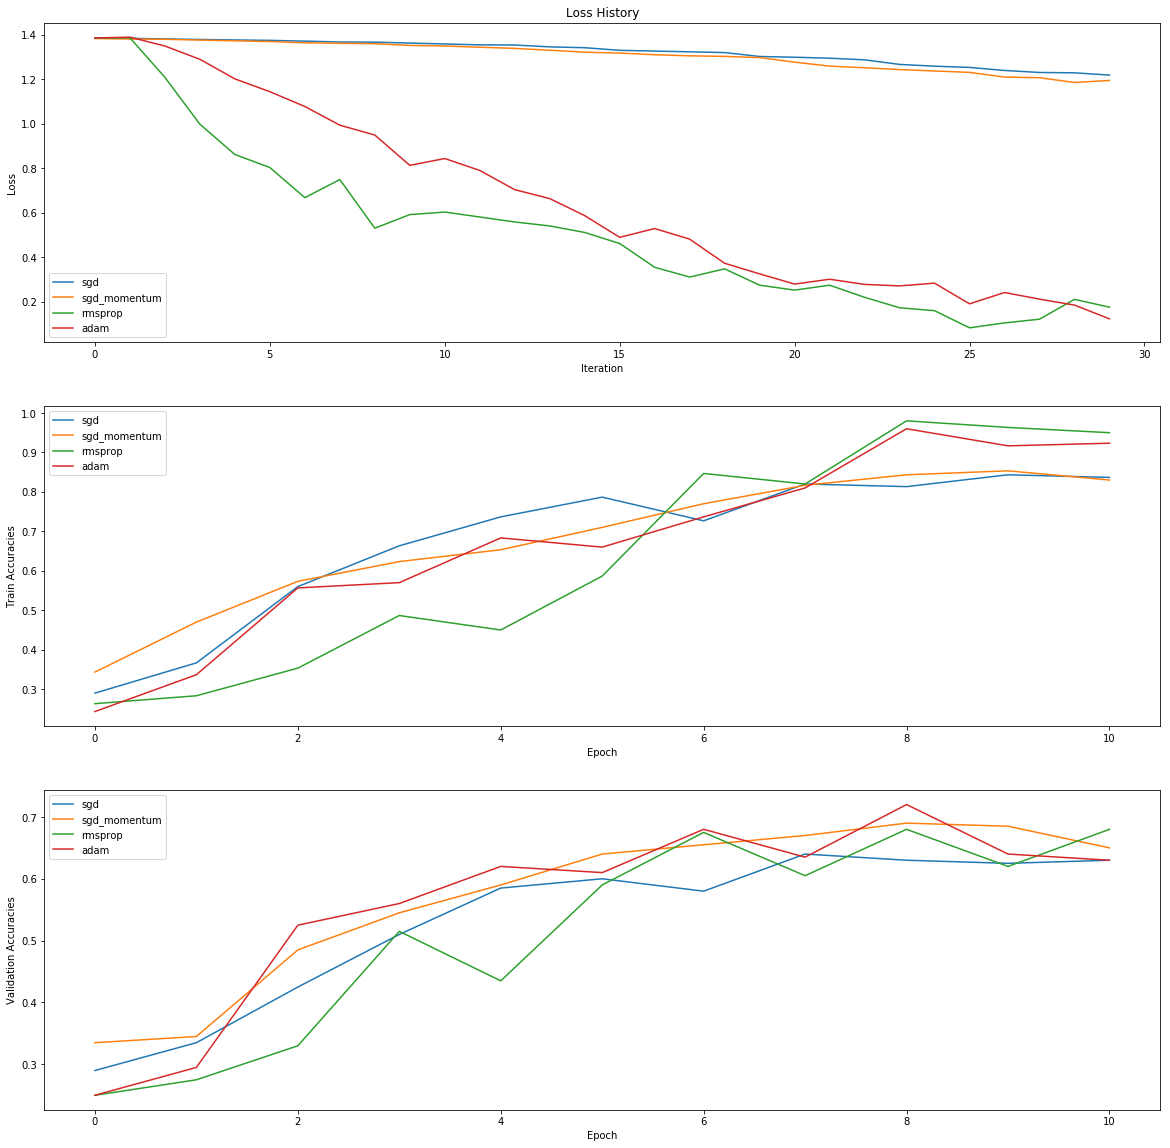

In [131]:
# plot loss history and train/ validation accuracies history
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots
plt.subplot(3,1,1) 
for idx, name in enumerate(optim):
    plt.plot(optim_hist[idx][0], label=name)# plot all loss curve
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,1,2)
for idx, name in enumerate(optim):
    plt.plot(optim_hist[idx][1], label=name)#Plot train accuracy
plt.xlabel('Epoch')
plt.ylabel('Train Accuracies')
plt.legend()

plt.subplot(3,1,3)
for idx, name in enumerate(optim):
    plt.plot(optim_hist[idx][2], label=name)#Plot train accuracy
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracies')
plt.legend()

plt.show()


## Batchnorm or Layer norm
#### Prediction
- Layer norm will have larger impact on model as the input have high dimension (Wrong)

#### Result
- **Batch norm** work best for sure


In [145]:
train_data = {} 
train_data['X'] = data['X_dev']
train_data['y'] = data['y_dev'] 
train_data['X_val'] = data['X_val']
train_data['y_val'] = data['y_val']

norms = ['batchnorm', 'layernorm']
norms_hist = []
for n in norms:
    print("Normalization:",n)
    model = NeuralNet.NeuralNet(hidden_dims = [100, 100, 100], 
                input_dim = im_channel * im_height * im_width,
                num_classes = np.max(y_train) + 1, 
                dropout = 0.5,
                normalization = n, 
                reg = 0.0,
                weight_scale = 1e-3)

    trainer = Trainer(model, train_data, 
                     update_rule='rmsprop',
                     optim_config={
                         'learning_rate': 1e-3
                     },
                     lr_decay=0.95,
                     num_epochs=10, batch_size=100,
                     print_every=50)
    trainer.train()
    norms_hist.append((trainer.loss_history, trainer.train_acc_history, trainer.val_acc_history))
    del trainer 
    del model


Normalization: batchnorm
Training...
(Iteration 1 / 30) loss: 1.386496
(Epoch 0 / 10) train acc: 0.313333; val_acc: 0.285000
(Epoch 1 / 10) train acc: 0.263333; val_acc: 0.250000
(Epoch 2 / 10) train acc: 0.453333; val_acc: 0.405000
(Epoch 3 / 10) train acc: 0.410000; val_acc: 0.370000
(Epoch 4 / 10) train acc: 0.590000; val_acc: 0.585000
(Epoch 5 / 10) train acc: 0.800000; val_acc: 0.670000
(Epoch 6 / 10) train acc: 0.786667; val_acc: 0.675000
(Epoch 7 / 10) train acc: 0.826667; val_acc: 0.660000
(Epoch 8 / 10) train acc: 0.783333; val_acc: 0.640000
(Epoch 9 / 10) train acc: 0.830000; val_acc: 0.655000
(Epoch 10 / 10) train acc: 0.843333; val_acc: 0.645000
Normalization: layernorm
Training...
(Iteration 1 / 30) loss: 1.386298
(Epoch 0 / 10) train acc: 0.253333; val_acc: 0.250000
(Epoch 1 / 10) train acc: 0.253333; val_acc: 0.250000
(Epoch 2 / 10) train acc: 0.296667; val_acc: 0.315000
(Epoch 3 / 10) train acc: 0.256667; val_acc: 0.245000
(Epoch 4 / 10) train acc: 0.270000; val_acc: 0.

## Dropout ? 
#### Introduction 
- Dropout avoid overfiting. 
- Allow model to not depend on anyweight too much

#### Prediction 
- Dropout will impact the testime accuracies of the model in many way. as all the input data is highly correlate(Correct)

#### Experiment
- Apply a range of droping rate on Model to investigate the impact on model. 

#### Result
- As Dropping rate decrease(Probability # of neuron to keep), the validation accuracy increase. There are many trade off when applying this technique on model .
    - Model will have hard time to converge as seen in graph below. Loss History curve of model with `0.25` rate have way smaller loss the extend much further. 
- As Droping rate increase, the validation decrease with train accuracy increase. This cause the model to have large gap between train acccuracy and validation accuracy. Model will be ver sensitive when there is high droping rate 

#### Winner rate
- `0.5` dropping is the best. As if we go for a too low or too high rate, then there is a lot of trade off. 

In [137]:
train_data = {} 
train_data['X'] = data['X_dev']
train_data['y'] = data['y_dev'] 
train_data['X_val'] = data['X_val']
train_data['y_val'] = data['y_val']

#Note: here dropout_rate indicate the keeping propbability
dropout_rate = [0.25, 0.5, 0.75, 1.0]
rates_hist = [] 

for rate in dropout_rate:
    print("Dropout rate:",rate)
    model = NeuralNet.NeuralNet(hidden_dims = [100, 100, 100], 
                input_dim = im_channel * im_height * im_width,
                num_classes = np.max(y_train) + 1, 
                dropout = rate,
                normalization = 'batchnorm', 
                reg = 0.0,
                weight_scale = 1e-3)

    trainer = Trainer(model, train_data, 
                     update_rule='rmsprop',
                     optim_config={
                         'learning_rate': 1e-3
                     },
                     lr_decay=0.95,
                     num_epochs=10, batch_size=100,
                     print_every=50)
    trainer.train()
    rates_hist.append((trainer.loss_history, trainer.train_acc_history, trainer.val_acc_history))
    del trainer 
    del model


Dropout rate: 0.25
Training...
(Iteration 1 / 30) loss: 1.387062
(Epoch 0 / 10) train acc: 0.243333; val_acc: 0.255000
(Epoch 1 / 10) train acc: 0.283333; val_acc: 0.270000
(Epoch 2 / 10) train acc: 0.340000; val_acc: 0.335000
(Epoch 3 / 10) train acc: 0.360000; val_acc: 0.375000
(Epoch 4 / 10) train acc: 0.553333; val_acc: 0.580000
(Epoch 5 / 10) train acc: 0.666667; val_acc: 0.690000
(Epoch 6 / 10) train acc: 0.630000; val_acc: 0.595000
(Epoch 7 / 10) train acc: 0.683333; val_acc: 0.665000
(Epoch 8 / 10) train acc: 0.736667; val_acc: 0.720000
(Epoch 9 / 10) train acc: 0.736667; val_acc: 0.700000
(Epoch 10 / 10) train acc: 0.753333; val_acc: 0.720000
Dropout rate: 0.5
Training...
(Iteration 1 / 30) loss: 1.389134
(Epoch 0 / 10) train acc: 0.263333; val_acc: 0.250000
(Epoch 1 / 10) train acc: 0.263333; val_acc: 0.250000
(Epoch 2 / 10) train acc: 0.393333; val_acc: 0.405000
(Epoch 3 / 10) train acc: 0.453333; val_acc: 0.415000
(Epoch 4 / 10) train acc: 0.743333; val_acc: 0.725000
(Epoch

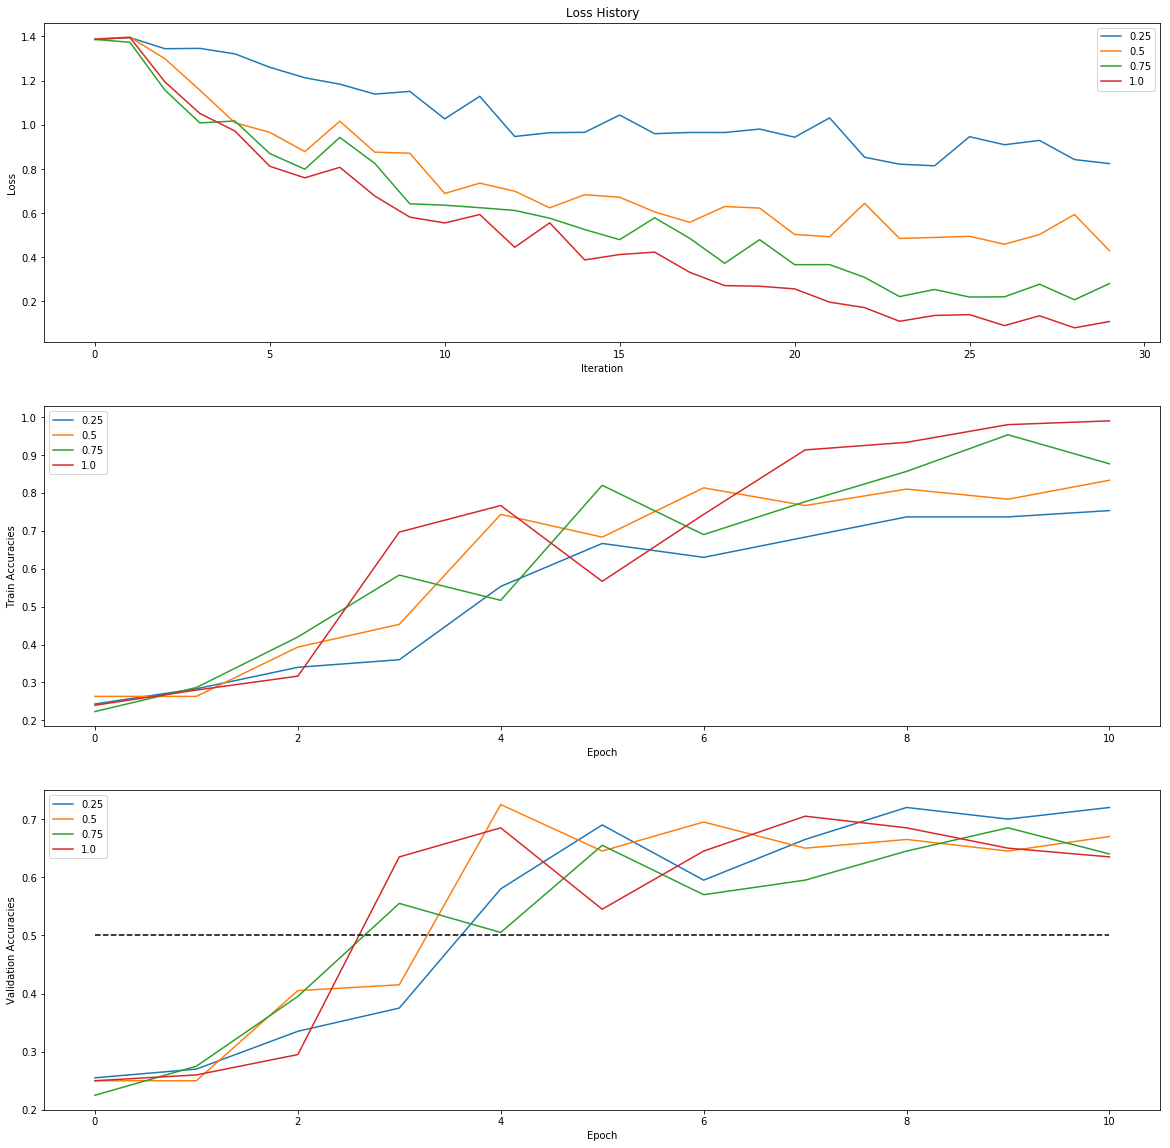

In [143]:
# plot loss history and train/ validation accuracies history
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots
plt.subplot(3,1,1) 
for idx, rate in enumerate(dropout_rate):
    plt.plot(rates_hist[idx][0], label=str(rate))# plot all loss curve
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,1,2)
for idx, rate in enumerate(dropout_rate):
    plt.plot(rates_hist[idx][1], label=str(rate))#Plot train accuracy
plt.xlabel('Epoch')
plt.ylabel('Train Accuracies')
plt.legend()

plt.subplot(3,1,3)
for idx, rate in enumerate(dropout_rate):
    plt.plot(rates_hist[idx][2], label=str(rate))#Plot train accuracy
#Draw mid line 
plt.plot([0.5] * len(rates_hist[2][2]), 'k--')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracies')
plt.legend()

plt.show()

## Train a Good Model

NameError: name 'best_net' is not defined

In [17]:
#Import necessary package to build net model
import nettool
from nettool.trainer import *
from nettool.layers import * 
from nettool.layer_utils import * 
from nettool.models import NeuralNet


train_data = {} 
train_data['X'] = data['X_train']
train_data['y'] = data['y_train'] 
train_data['X_val'] = data['X_val']
train_data['y_val'] = data['y_val']


best_net = NeuralNet.NeuralNet(hidden_dims = [100, 100, 100], 
            input_dim = im_channel * im_height * im_width,
            num_classes = np.max(y_train) + 1, 
            dropout = 0.5,
            normalization = 'batchnorm', 
            reg = 0.0,
            weight_scale = 1e-3)

best_school = Trainer(best_net, train_data, 
                 update_rule='rmsprop',
                 optim_config={
                     'learning_rate': 1e-3
                 },
                 lr_decay=0.95,
                 num_epochs=10, batch_size=100,
                 print_every=50)
best_school.train()


Training...
(Iteration 1 / 400) loss: 1.387645
(Epoch 0 / 10) train acc: 0.279000; val_acc: 0.280000
(Epoch 1 / 10) train acc: 0.737000; val_acc: 0.710000
(Iteration 51 / 400) loss: 0.647630
(Epoch 2 / 10) train acc: 0.774000; val_acc: 0.750000
(Iteration 101 / 400) loss: 0.582598
(Epoch 3 / 10) train acc: 0.738000; val_acc: 0.700000
(Iteration 151 / 400) loss: 0.643022
(Epoch 4 / 10) train acc: 0.829000; val_acc: 0.745000
(Epoch 5 / 10) train acc: 0.801000; val_acc: 0.750000
(Iteration 201 / 400) loss: 0.621811
(Epoch 6 / 10) train acc: 0.872000; val_acc: 0.760000
(Iteration 251 / 400) loss: 0.502830
(Epoch 7 / 10) train acc: 0.883000; val_acc: 0.775000
(Iteration 301 / 400) loss: 0.511978
(Epoch 8 / 10) train acc: 0.881000; val_acc: 0.775000
(Iteration 351 / 400) loss: 0.388670
(Epoch 9 / 10) train acc: 0.894000; val_acc: 0.765000
(Epoch 10 / 10) train acc: 0.896000; val_acc: 0.780000


In [18]:
print("Accuracy on val set", (best_net.predict( data['X_test']) == data['y_test']).mean())  

Accuracy on val set 0.785


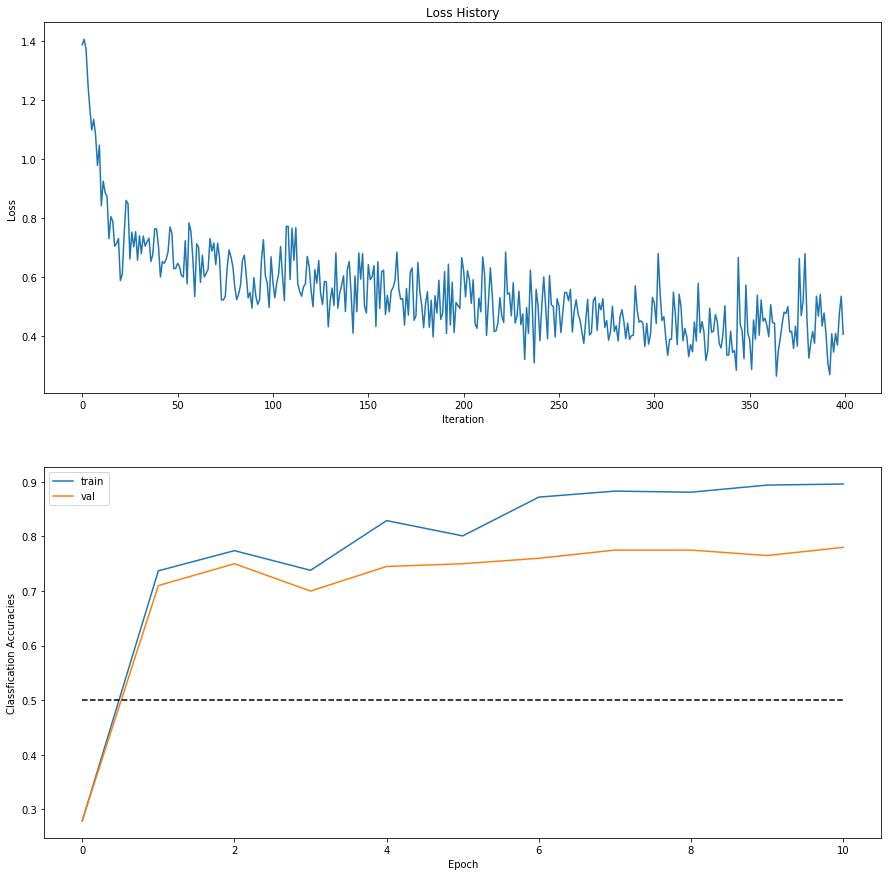

In [21]:
# plot loss history and train/ validation accuracies history
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.subplot(2,1,1) 
plt.plot(best_school.loss_history)
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(best_school.train_acc_history, label='train')
plt.plot(best_school.val_acc_history, label='val')
#Draw mid line 
plt.plot([0.5] * len(best_school.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.ylabel('Classfication Accuracies')
plt.legend()
plt.show()

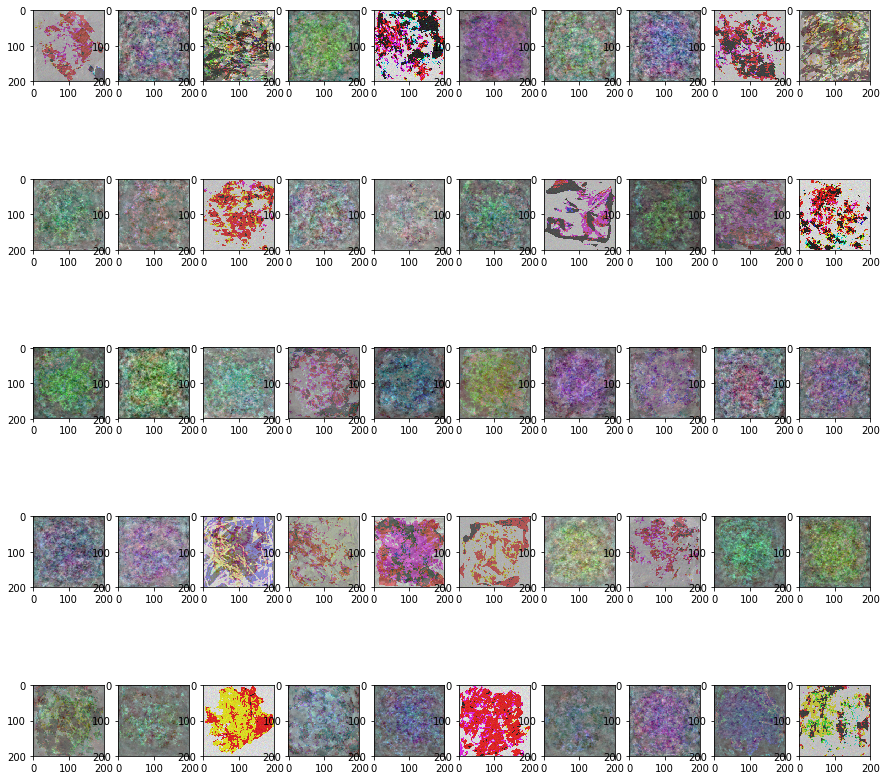

In [22]:
#Visualize the weight of the first layer
columns = 10 
rows = 5

c = 40
fig, ax_array = plt.subplots(rows, columns, squeeze=True)
for i, ax_row in enumerate(ax_array):
    for j, axes  in enumerate(ax_row):
        #Scale weight to get new min max 
        bars = best_net.params['W1'][:,c]
        bars = (255-0) * (bars - bars.min()) / (bars.max() - bars.min()) + 0
        axes.imshow(bars.reshape(im_width, im_height, im_channel).astype('uint8'))
        c += 1

plt.show()

(array([   41.,   549.,  4351., 17012., 34949., 37071., 19846.,  5381.,
          753.,    47.]),
 array([-4.2863195e-03, -3.4419759e-03, -2.5976324e-03, -1.7532888e-03,
        -9.0894522e-04, -6.4601656e-05,  7.7974191e-04,  1.6240855e-03,
         2.4684290e-03,  3.3127726e-03,  4.1571162e-03], dtype=float32),
 <a list of 10 Patch objects>)

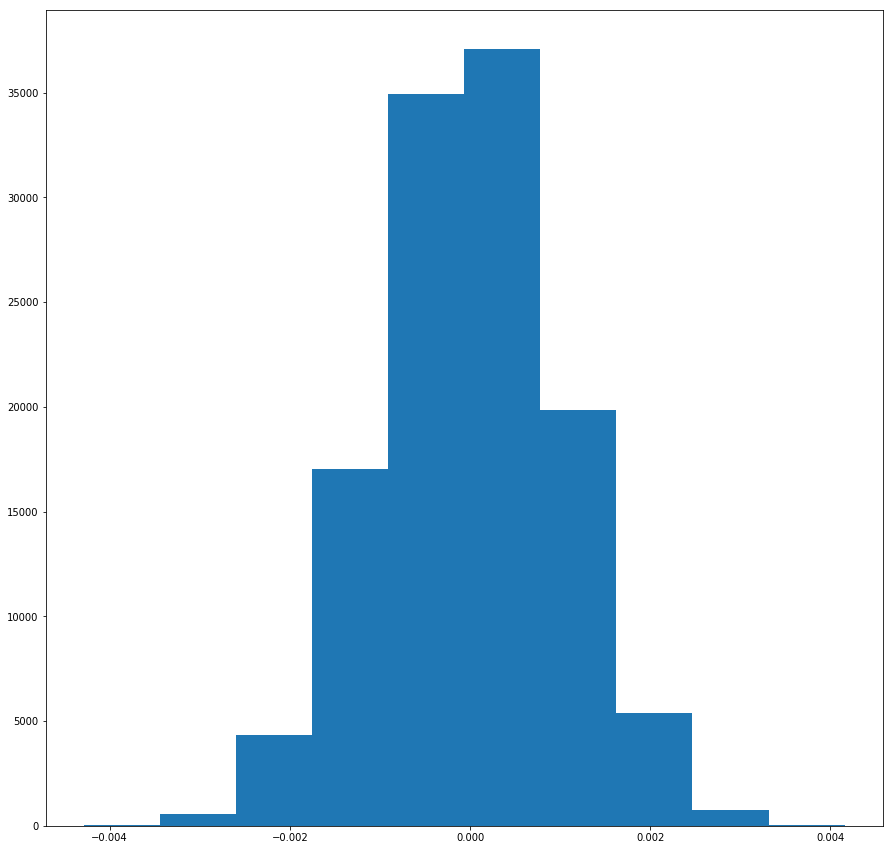

In [90]:
plt.hist(model.params['W1'][:,40].ravel())

In [28]:
bars = model.params['W1'][:,50]
bars = (255-0) * (bars - bars.min()) / (bars.max() - bars.min()) + 0
plt.imshow(bars.reshape(im_width, im_height, im_channel).astype('uint8'))

NameError: name 'model' is not defined

In [25]:
from math import sqrt, ceil
def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid


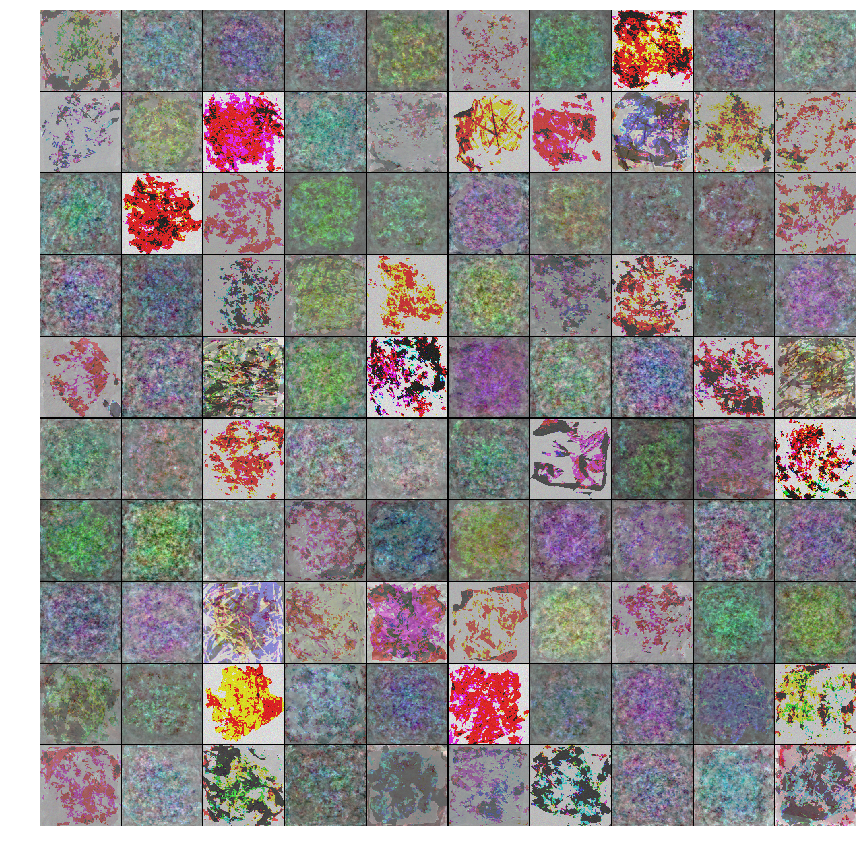

In [27]:
def show_net_weights(model):
    W1 = model.params['W1']
    W1 = W1.reshape(im_height, im_width, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(best_net)

## Traine a Good Model 

In [ ]:
#Import necessary package to build net model
import nettool
from nettool.trainer import *
from nettool.layers import * 
from nettool.layer_utils import * 
from nettool.models import NeuralNet


model = NeuralNet.NeuralNet(hidden_dims = [200, 100, 100], 
                input_dim = im_channel * im_height * im_width,
                num_classes = np.max(y_train) + 1, 
                dropout = 1.0,
                normalization = 'batchnorm', 
                reg = 0.0,
                weight_scale = 1e-3)


train_data = {} 
train_data['X'] = data['X_train']
train_data['y'] = data['X_train'] 
train_data['X_val'] = data['X_val']
train_data['y_val'] = data['y_val']
trainer = Trainer(model, train_data, 
                 update_rule='sgd',
                 optim_config={
                     'learning_rate': 1e-3
                 },
                 lr_decay=0.95,
                 num_epochs=10, batch_size=200,
                 print_every=100)
trainer.train()